In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.lines as mlines
from IPython.display import display, Latex
from scipy.optimize import minimize

import matplotlib as mpl
mpl.rcParams["hatch.linewidth"] = 0.5  # previous svg hatch linewidth

Consider the following optimization problem

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & f(x_1,x_2) = 3x_1^2+x_2^2\\
		& \text{subject to}
		& & g_1(x_1,x_2) = 2 - x_2 - x_1 \le 0\\
	\end{aligned}
\end{equation*}

We first define the limits over which we want to examine the function below. Namely, $x_1,x_2\in[-5,5]$.

In [2]:
# Problem definition
lb = [-5, -5]
ub = [5, 5]

# for creating hatched constraints
def constraint_color(cf,color):
    # https://github.com/matplotlib/matplotlib/issues/2789/#issuecomment-604599060
    for i, collection in enumerate(cf.collections):
        collection.set_edgecolor(color)

n = 50
x1 = np.linspace(lb[0],ub[0],n)
x2 = np.linspace(lb[0],ub[0],n)
X1, X2 = np.meshgrid(x1,x2)
F = 3*X1**2+X2**2
G1 = 2 - X2 - X1

# Penalty function method (also known as exterior point penalty)

In this approach, we start with an infeasible initial guess $\mathbf{x}_0$ and work our way towards the constrained optimizer $\mathbf{x}^*$. We define the penalty function as:
$$
P(\mathbf{x}) = \sum_{j=1}^m \max \{0,g_j(\mathbf{x}) \}^2
$$
where $m$ is the number of constraints. For the above problem, we only have one constraint. We then transform the constrained minimization problem into an unconstrained one and solve it for each $r_k$ in the sequence $\left\{r_k\right\}$

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{x}}{\text{minimize}}
		& & T(\mathbf{x},r_k) = f(\mathbf{x}) + \dfrac{1}{r_k}P(\mathbf{x})\\
	\end{aligned}
\end{equation*}

For the problem in this example notebook, the corresponding unconstrained problem becomes:

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & T(x_1,x_2,r_k) = 3x_1^2+x_2^2 + \dfrac{1}{r_k}\max \{0,2-x_1-x_2 \}^2\\
	\end{aligned}
\end{equation*}

The gradient $\nabla T(\mathbf{x},r_k)$ for the above problem becomes:
$$
\nabla T(\mathbf{x},r_k) = \begin{bmatrix} 6x_1 - \dfrac{\max\{0,2-x_1-x_2\}}{r_k} \\ 2x_2 - \dfrac{\max\{0,2-x_1-x_2\}}{r_k} \end{bmatrix}
$$

We can now solve the above unconstrained problems using any of the unconstrained gradient based approaches we covered in Lecture 5 (see the examples in [5_unconstrained_algorithms]("../5_unconstrained_algorithms")). We will use ``scipy.optimize.minimize`` to solve the above problem which use the Quasi-Newton method with BFGS for the Hessian approximation by default.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

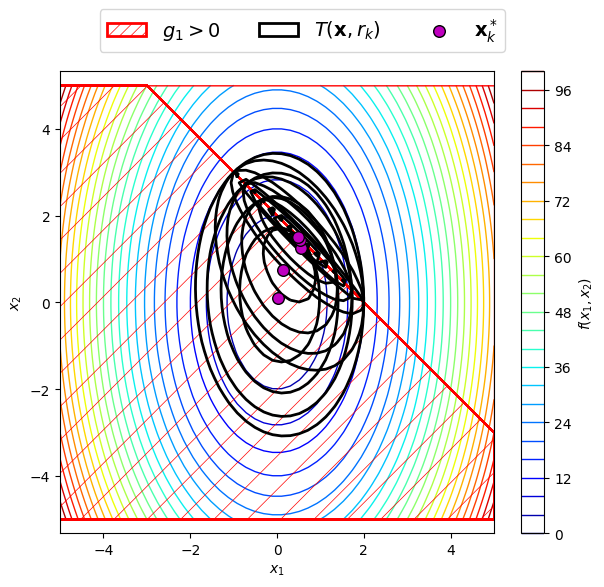

In [3]:
fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contour(X1, X2, F,cmap="jet",levels=25,zorder=-1,linewidths=1)
fig.colorbar(cf, ax=ax, orientation="vertical", label=r"$f(x_1,x_2)$")

handles = []; labels = []
# Constraints
cf = ax.contourf(X1, X2, G1, levels=[-200, 0, 200], colors="none",hatches=[None, "/"],extend="lower")
constraint_color(cf,"r")
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="r", facecolor="none", fill="None", hatch="///")
handles += [a_hatch]
labels += [r"$g_1>0$"]

# %% optimization begins here
def obj(x):
    """The objective"""
    return 3*x[0]**2 + x[1]**2 + max(0,((2-x[0]-x[1])**2)/rk); 

def grad(x):
    """The gradient"""
    return [6*x[0]-max(0,(2-x[0]-x[1])/rk), 2*x[1]-max(0,(2-x[0]-x[1])/rk)]

r = [10.0, 1.0, 0.1, 0.01, 0.001] # sequence of decreasing r"s
r = r[0:5]
x0 = [0,0]
for k,rk in enumerate(r):

    FAL = np.empty(F.shape)
    for j in range(len(x2)):
        for i in range(len(x1)):
            FAL[j,i] = obj([x1[i],x2[j]])
    
    V = range(0,15,3)
    cf = ax.contour(X1, X2, FAL,colors="k",levels=V,zorder=1,linewidths=2.0)

    x_opt = minimize(obj,x0,jac=grad,method="BFGS",options={"gtol": 1e-8, "maxiter": 1000, "disp": False})
    f_opt = obj(x_opt.x)

    # optimizer
    opt = ax.scatter([x_opt.x[0],], [x_opt.x[1],], s = 70, marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_k^*$",zorder=3)

    x0 = x_opt.x

    print("===========================")
    display(Latex(r"$k = %i$" %(k+1)))
    display(Latex(r"$\mathbf{x}_k^*$ = $[%.4f~~%.4f]^\mathrm{T}$" %(x_opt.x[0],x_opt.x[1])))

# label and handle for penalty function
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="k", facecolor="none", fill="None")
handles += [a_hatch]
labels += [r"$T(\mathbf{x},r_k)$"]

# label and handle for optimizers
handles += [opt]
labels += [r"$\mathbf{x}_k^*$"]

# legend
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis("equal")
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[0],ub[0]))
lx = fig.legend(handles, labels, loc="upper center", ncol=3, fontsize = 14)
# fig.savefig("penalty_ex_5.pdf",bbox_inches="tight")
plt.show()

We can see that the successive unconstrained minimizers $\mathbf{x}_k^*$ brought use closer to the true constrained minimizer $\mathbf{x}^*$.

# Barrier function method (also known as interior point penalty)

In this approach, we start with a **feasible** initial guess $\mathbf{x}_0$ and work our way towards the constrained optimizer $\mathbf{x}^*$. We define the barrier function as:
$$
B(x) = -\sum_{j=1}^m \frac{1}{g_j(x)}
$$
where $m$ is the number of constraints. For the above problem, we only have one constraint. The barrier function is **only defined in the feasible space (not including the constraint boundary)** i.e., when $\mathbf{g}(\mathbf{x}) < 0$.

We then transform the constrained minimization problem into an unconstrained one and solve it for each $r_k$ in the sequence $\left\{r_k\right\}$

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{x}}{\text{minimize}}
		& & T(\mathbf{x},r_k) = f(\mathbf{x}) + {r_k}B(\mathbf{x})\\
	\end{aligned}
\end{equation*}

For the problem in this example notebook, the corresponding unconstrained problem becomes:

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & T(x_1,x_2,r_k) = 3x_1^2+x_2^2 + \dfrac{r_k}{2-x_1-x_2}\\
	\end{aligned}
\end{equation*}

The gradient $\nabla T(\mathbf{x},r_k)$ for the above problem becomes:
$$
\nabla T(\mathbf{x},r_k) = \begin{bmatrix} 6x_1 - \dfrac{r_k}{x_1+x_2-2} \\ 2x_2 - \dfrac{r_k}{x_1+x_2-2} \end{bmatrix}
$$

We can now solve the above unconstrained problems using ``scipy.optimize.minimize``.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

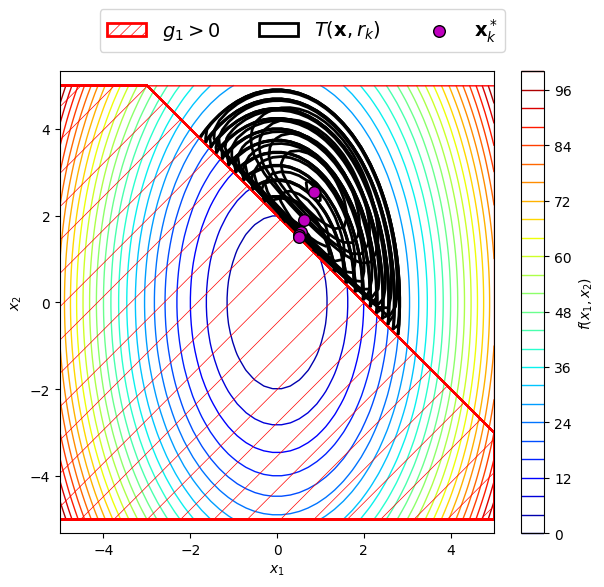

In [4]:
fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contour(X1, X2, F,cmap="jet",levels=25,zorder=-1,linewidths=1)
fig.colorbar(cf, ax=ax, orientation="vertical", label=r"$f(x_1,x_2)$")

handles = []; labels = []
# Constraints
cf = ax.contourf(X1, X2, G1, levels=[-200, 0, 200], colors="none",hatches=[None, "/"],extend="lower")
constraint_color(cf,"r")
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="r", facecolor="none", fill="None", hatch="///")
handles += [a_hatch]
labels += [r"$g_1>0$"]

# %% optimization begins here
def obj(x):
    """The objective"""
    if 2-x[0]-x[1] < 0:
        return 3*x[0]**2+x[1]**2-rk/(2-x[0]-x[1])
    else:
        return np.Inf

def grad(x):
    """The gradient"""
    if 2-x[0]-x[1] < 0:
        return [6*x[0]-rk/(x[0]+x[1]-2)**2, 2*x[1]-rk/(x[0]+x[1]-2)**2]
    else:
        return [np.Inf, np.Inf]

r = [10.0, 1.0, 0.1, 0.01, 0.001] # sequence of decreasing r"s
r = r[0:5]
x0 = [5,5]
for k,rk in enumerate(r):

    FAL = np.empty(F.shape)
    for j in range(len(x2)):
        for i in range(len(x1)):
            FAL[j,i] = obj([x1[i],x2[j]])
    
    V = range(0,25,2)
    cf = ax.contour(X1, X2, FAL,colors="k",levels=V,zorder=1,linewidths=2.0)

    x_opt = minimize(obj,x0,jac=grad,method="BFGS",options={"gtol": 1e-8, "maxiter": 1000, "disp": False})
    f_opt = obj(x_opt.x)

    # optimizer
    opt = ax.scatter([x_opt.x[0],], [x_opt.x[1],], s = 70, marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_k^*$",zorder=3)

    x0 = x_opt.x

    print("===========================")
    display(Latex(r"$k = %i$" %(k+1)))
    display(Latex(r"$\mathbf{x}_k^*$ = $[%.4f~~%.4f]^\mathrm{T}$" %(x_opt.x[0],x_opt.x[1])))

# label and handle for penalty function
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="k", facecolor="none", fill="None")
handles += [a_hatch]
labels += [r"$T(\mathbf{x},r_k)$"]

# label and handle for optimizers
handles += [opt]
labels += [r"$\mathbf{x}_k^*$"]

# legend
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis("equal")
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[0],ub[0]))
lx = fig.legend(handles, labels, loc="upper center", ncol=3, fontsize = 14)
# fig.savefig("barrier_ex_5.pdf",bbox_inches="tight")
plt.show()

We can see that the successive unconstrained minimizers $\mathbf{x}_k^*$ brought use closer to the true constrained minimizer $\mathbf{x}^*$. We can also see that the eccentricity of the penalized objectives $T(\mathbf{x},r_k)$ grows the closer towards the constraint. This may cause numerical issues with the unconstrained optimization algorithms.

# The augmented Lagrangian method

In this approach, we can start **anywhere** with an initial guess $\mathbf{x}_0$ and work our way towards the constrained optimizer $\mathbf{x}^*$. We use the penalty function $P(\mathbf{x}) = \sum_{j=1}^m \max \{0,g_j(\mathbf{x}) \}^2$ from before and combine it with the Lagrangian formulation of the constrained minimization problem such that we obtain an unconstrained minimization problem $r_k$ in the sequence $\left\{r_k\right\}$

\begin{equation*}
	\begin{aligned}
		& \underset{\mathbf{x}}{\text{minimize}}
		& & T(\mathbf{x},r_k) = f(\mathbf{x}) + \boldsymbol{\mu}^\mathrm{T}\mathbf{g} + \dfrac{1}{r_k}P(\mathbf{x})\\
	\end{aligned}
\end{equation*}

For the problem in this example notebook, the corresponding unconstrained problem becomes:

\begin{equation*}
	\begin{aligned}
		& \underset{x_1,x_2}{\text{minimize}}
		& & T(x_1,x_2,r_k) = 3x_1^2+x_2^2 + \lambda_k\left(2-x_1-x_2\right)+\dfrac{1}{r_k}\max \{0,2-x_1-x_2 \}^2\\
	\end{aligned}
\end{equation*}

The gradient $\nabla T(\mathbf{x},r_k)$ for the above problem becomes:
$$
\nabla T(\mathbf{x},r_k) = \begin{bmatrix} 6x_1 - \lambda_k - \dfrac{\max\{0,2-x_1-x_2\}}{r_k} \\ 2x_2 - \lambda_k - \dfrac{\max\{0,2-x_1-x_2\}}{r_k} \end{bmatrix}
$$

We have to update $\lambda_k$ at each iteration $k$ according to

$$\lambda_{k+1} = \lambda_k + \dfrac{2}{r_k}g(x_1,x2)$$

We can now solve the above unconstrained problems using ``scipy.optimize.minimize``.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

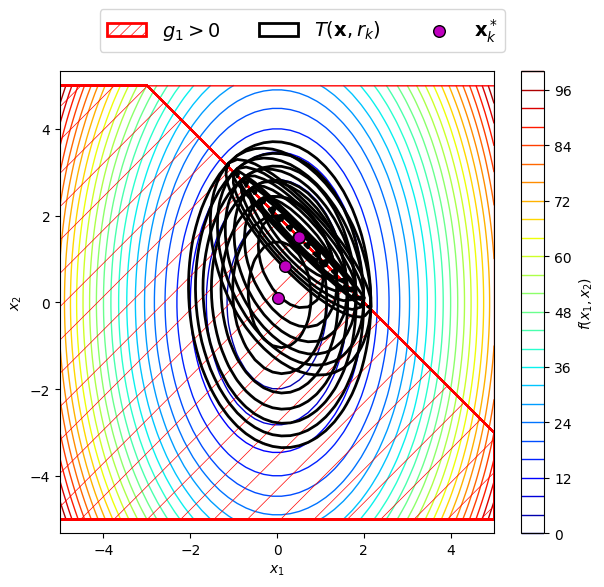

In [5]:
fig, ax = plt.subplots(figsize=(7,6))
cf = ax.contour(X1, X2, F,cmap="jet",levels=25,zorder=-1,linewidths=1)
fig.colorbar(cf, ax=ax, orientation="vertical", label=r"$f(x_1,x_2)$")

handles = []; labels = []
# Constraints
cf = ax.contourf(X1, X2, G1, levels=[-200, 0, 200], colors="none",hatches=[None, "/"],extend="lower")
constraint_color(cf,"r")
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="r", facecolor="none", fill="None", hatch="///")
handles += [a_hatch]
labels += [r"$g_1>0$"]

# %% optimization begins here
def obj(x):
    """The objective"""
    return 3*x[0]**2 + x[1]**2 + lambda_k*(2-x[0]-x[1]) + max(0,((2-x[0]-x[1])**2)/rk); 

def grad(x):
    """The gradient"""
    return [6*x[0]-lambda_k-max(0,(2-x[0]-x[1])/rk), 2*x[1]-lambda_k-max(0,(2-x[0]-x[1])/rk)]

r = [10.0, 1.0, 0.1, 0.01, 0.001] # sequence of decreasing r"s
r = r[0:5]
lambda_k = 0
x0 = [0,0]
for k,rk in enumerate(r):

    FAL = np.empty(F.shape)
    for j in range(len(x2)):
        for i in range(len(x1)):
            FAL[j,i] = obj([x1[i],x2[j]])
    
    V = range(0,15,2)
    cf = ax.contour(X1, X2, FAL,colors="k",levels=V,zorder=1,linewidths=2)

    x_opt = minimize(obj,x0,jac=grad,method="BFGS",options={"gtol": 1e-8, "maxiter": 1000, "disp": False})
    f_opt = obj(x_opt.x)

    # optimizer
    opt = ax.scatter([x_opt.x[0],], [x_opt.x[1],], s = 70, marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_k^*$",zorder=3)

    x0 = x_opt.x
    lambda_k = lambda_k + 2*(2-x_opt.x[0]-x_opt.x[1])/rk

    print("===========================")
    display(Latex(r"$k = %i$" %(k+1)))
    display(Latex(r"$\lambda_k = %.4f$" %lambda_k))
    display(Latex(r"$\mathbf{x}_k^*$ = $[%.4f~~%.4f]^\mathrm{T}$" %(x_opt.x[0],x_opt.x[1])))

# label and handle for penalty function
a_hatch = patches.Rectangle((20,20), 20, 20, linewidth=2, edgecolor="k", facecolor="none", fill="None")
handles += [a_hatch]
labels += [r"$T(\mathbf{x},r_k)$"]

# label and handle for optimizers
handles += [opt]
labels += [r"$\mathbf{x}_k^*$"]

# legend
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis("equal")
ax.set_xlim((lb[0],ub[0]))
ax.set_ylim((lb[0],ub[0]))
lx = fig.legend(handles, labels, loc="upper center", ncol=3, fontsize = 14)
# fig.savefig("AL_ex_1.pdf",bbox_inches="tight")
plt.show()

We can see that the successive unconstrained minimizers $\mathbf{x}_k^*$ obtained from the Augmented Lagrangian method brought use closer to the true constrained minimizer $\mathbf{x}^*$. This method also seems to converge faster than the penalty method.